# Tarea 7: Simulación de Clima con Cadenas de Markov

## 1. Objetivos

### Objetivo Principal
Modelar y simular el comportamiento climático de una estación meteorológica chilena utilizando Cadenas de Markov de tiempo discreto y simulaciones de Montecarlo, basándose en datos históricos.

### Objetivos Específicos
1.  Extraer y procesar datos históricos de múltiples variables climatológicas (2002-2024) para la estación "El Tepual, Puerto Montt" (Cód: 410005) desde el sitio de MeteoChile.
2.  Discretizar la variable continua "Temperatura Media Anual" en tres estados categóricos: "Frio", "Templado" y "Caluroso".
3.  Calcular las 12 matrices de transición de probabilidad (una para cada mes) basadas en las transiciones diarias históricas (Actividad 3).
4.  Realizar 100 simulaciones de Montecarlo de 30 días para cada mes para estimar la distribución climática (Actividad 4).
5.  Calcular analíticamente los estados estacionarios para cada matriz mensual y compararlos con los resultados de la simulación (Actividad 5).
6.  Visualizar una matriz de transición (Julio) como un grafo de estados (Actividad 6).

## 2. Librerías y Configuración

Primero, importamos todas las librerías necesarias para el análisis:
* `urllib.request` y `io` para la descarga y lectura de datos web (scraping).
* `pandas` y `numpy` para la manipulación y análisis de datos.
* `time` para pausar el script y evitar saturar el servidor de MeteoChile.
* `matplotlib.pyplot` y `networkx` para la visualización de datos y grafos.
* `eig` de `numpy.linalg` para el cálculo de estados estacionarios.

Definimos las variables globales: la estación, el rango de años, las variables a extraer y el mapa de meses.

In [40]:
import urllib.request as ureq
import pandas as pd
import numpy as np
import time 
import io
import matplotlib.pyplot as plt
from numpy.linalg import eig
import networkx as nx

## 3. Extracción y Limpieza de Datos (Actividad 1)

Iteramos sobre cada variable (`variables`) y cada año (`años`) para construir la URL de consulta.

Mediante `urllib.request.urlopen` descargamos el contenido HTML de la página. Usamos `pd.read_html` (con la ayuda de `io.BytesIO`) para convertir la tabla HTML en un DataFrame de pandas.

Luego, realizamos los siguientes pasos de limpieza y transformación:
1.  **Limpieza de Nombres:** Renombramos las columnas para que sean consistentes.
2.  **Melt (Ancho a Largo):** Transformamos la tabla (donde los meses son columnas) a un formato largo (donde 'Mes' y 'Valor' son columnas).
3.  **Mapeo de Fechas:** Convertimos el nombre del mes (ej. "Enero") a su número (1) usando `mesMap`.
4.  **Creación de Fecha:** Combinamos "Día", "Mes_Num" y "Año" para crear un índice temporal (`datetime`).
5.  **Concatenación:** Unimos todas las series anuales de una variable y las asignamos al DataFrame principal `dfCompleto`.

In [ ]:
# ----- Configuración de Parámetros -----
estacion = 410005  # El Tepual Puerto Montt Ap.
años = list(range(2002, 2025)) # Años 2002 a 2024 para usar variable de índice UV
variables = [
    "cieloCubiertoAnual", 
    "temperaturaMediaAnual", 
    "indiceUvbMaximoAnual", 
    "humedadAnual"
]

# Mapa de Mes (Corregido: de nombre a número)
mesMap = {
    "Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4,
    "Mayo": 5, "Junio": 6, "Julio": 7, "Agosto": 8,
    "Septiembre": 9, "Octubre": 10, "Noviembre": 11, "Diciembre": 12
}

# Creamos el DataFrame base con el rango de fechas correcto
idxFechas = pd.date_range(start='2002-01-01', end='2024-12-31', freq='D')
dfCompleto = pd.DataFrame(index=idxFechas)

urlbase = "https://climatologia.meteochile.gob.cl/application/anual"

# ----- Descarga y Procesamiento de datos -----

for v in variables:
    print(f"--- Procesando variable: {v} ---")
    lista_series_anuales = []
    
    for a in años:
        url = f"{urlbase}/{v}/{str(estacion)}/{str(a)}"
        
        try:
            # Descargamos el HTML 
            pagina = ureq.urlopen(url)
            datos_html = pagina.read()
            
            # Extraemos la tabla (sabemos que es la primera [0])
            tabla_anual = pd.read_html(io.BytesIO(datos_html), header=1)[0]
            
            # Limpiamos nombres de columnas
            tabla_anual.columns = tabla_anual.columns.str.strip()
            dia_col = [col for col in tabla_anual.columns if "Día" in col][0]
            tabla_anual = tabla_anual.rename(columns={dia_col: "Día"})

            # Convertimos de formato ancho a largo
            df_long = tabla_anual.melt(id_vars=["Día"], var_name="Mes", value_name=v)

            # Mapeamos el nombre del mes a un número usando el diccionario
            df_long['Mes_Num'] = df_long['Mes'].str.strip().map(mesMap)

            # Convertimos los valores a numéricos (errores='coerce' los hace NaN si no son números)
            df_long['Día'] = pd.to_numeric(df_long['Día'], errors='coerce')
            df_long[v] = pd.to_numeric(df_long[v], errors='coerce')

            # Eliminamos las filas de resumen (ej. "Media Parcial") y datos faltantes
            df_long = df_long.dropna(subset=['Día', v, 'Mes_Num'])
            df_long["Año"] = a

            # Creamos una columna de fecha usando el Mes_Num
            df_long['Fecha'] = pd.to_datetime(df_long[['Año', 'Mes_Num', 'Día']].rename(columns={
                'Año': 'year', 'Mes_Num': 'month', 'Día': 'day'
            }), errors='coerce')
            
            # Eliminamos cualquier fecha inválida (ej. 30 de Feb)
            df_long = df_long.dropna(subset=['Fecha'])

            # Creamos la serie indexada por fecha
            serie_anual = df_long.set_index('Fecha')[v]

            # Guardamos la serie anual en la lista
            lista_series_anuales.append(serie_anual)

            time.sleep(1) # Pausa para no saturar el servidor

        except Exception as e:
            # Esto fallará para indiceUvbMaximoAnual en años antiguos (ej. 2002), lo cual es normal.
            print(f"  -> ADVERTENCIA al procesar año {a} para {v}: {e}")
    
    # Concatenamos todas las series anuales para esta variable
    if lista_series_anuales:
        serie_variable_completa = pd.concat(lista_series_anuales)
        # Usamos .combine_first() para rellenar el df principal sin sobreescribir datos buenos con NaNs
        dfCompleto[v] = serie_variable_completa

print("\n--- Extracción Finalizada ---")

# Verificamos la estructura y los datos no nulos
print(dfCompleto.info())

# Vemos los primeros días
print(dfCompleto.head())

--- Procesando variable: cieloCubiertoAnual ---
--- Procesando variable: temperaturaMediaAnual ---
--- Procesando variable: indiceUvbMaximoAnual ---
--- Procesando variable: humedadAnual ---

--- Extracción Finalizada ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8401 entries, 2002-01-01 to 2024-12-31
Freq: D
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   cieloCubiertoAnual     8171 non-null   float64
 1   temperaturaMediaAnual  8397 non-null   float64
 2   indiceUvbMaximoAnual   7740 non-null   float64
 3   humedadAnual           8394 non-null   float64
dtypes: float64(4)
memory usage: 328.2 KB
None
            cieloCubiertoAnual  temperaturaMediaAnual  indiceUvbMaximoAnual  \
2002-01-01                 5.0                   15.6                   NaN   
2002-01-02                 7.0                   13.5                   NaN   
2002-01-03                 4.0                   1

### 3.1. Relleno de Datos Faltantes (NaN)

El dataset extraído tiene valores `NaN` (Not a Number) en días donde no hubo reporte o la variable no existía (ej. Índice UV en 2002). Para que la cadena de Markov funcione (ya que necesita un estado para cada día), debemos rellenar estos vacíos.

Aplicamos la estrategia de **"forward fill" (`ffill`)**: asumimos que si un dato falta, el estado del día anterior se mantiene. Luego, usamos **"backward fill" (`bfill`)** para rellenar los `NaN` que pudieron quedar al inicio del dataset.

In [ ]:
# Rellenamos los NaN con el último valor válido anterior
dfCompleto.ffill(inplace=True)

# Rellenamos cualquier NaN que haya quedado al inicio del dataset (ej. 2002)
dfCompleto.bfill(inplace=True)

# Verifiquemos que no queden NaNs
print("--- Verificación de NaNs (debe ser 0) ---")
print(dfCompleto.isna().sum())

# Miremos los primeros días (indiceUvbMaximoAnual ahora debería tener datos)
print("\n--- DataFrame Relleno (head) ---")
print(dfCompleto.head())

--- Verificación de NaNs (debe ser 0) ---
cieloCubiertoAnual       0
temperaturaMediaAnual    0
indiceUvbMaximoAnual     0
humedadAnual             0
dtype: int64

--- DataFrame Relleno (head) ---
            cieloCubiertoAnual  temperaturaMediaAnual  indiceUvbMaximoAnual  \
2002-01-01                 5.0                   15.6                  12.0   
2002-01-02                 7.0                   13.5                  12.0   
2002-01-03                 4.0                   12.5                  12.0   
2002-01-04                 2.0                   14.0                  12.0   
2002-01-05                 2.0                   13.7                  12.0   

            humedadAnual  
2002-01-01          78.0  
2002-01-02          74.0  
2002-01-03          68.0  
2002-01-04          67.0  
2002-01-05          73.0  


## 4. Discretización de Estados (Actividad 2)

Las Cadenas de Markov requieren estados discretos (categóricos), pero nuestros datos de temperatura son continuos (ej. 10.5°C).

Basaremos nuestro modelo en la `temperaturaMediaAnual` y la discretizaremos en 3 estados: "Frio", "Templado" y "Caluroso".

Para definir los límites de estos estados, usamos un método estadístico: **cuantiles (terciles)**.
1.  Calculamos los percentiles 33.3% (`limite_frio`) y 66.6% (`limite_templado`) del historial de temperaturas.
2.  Usamos `pd.cut` para asignar a cada día su estado correspondiente en una nueva columna `Estado`.

In [46]:
temp_data = dfCompleto['temperaturaMediaAnual']

# Calculamos los valores que dividen los datos en 3 grupos (terciles)
limite_frio = temp_data.quantile(0.333)
limite_templado = temp_data.quantile(0.666)

print("\n--- Límites de Temperatura (Terciles) ---")
print(f"Límite Frío/Templado (Percentil 33.3): {limite_frio:.2f}°C")
print(f"Límite Templado/Caluroso (Percentil 66.6): {limite_templado:.2f}°C")

# Definimos los límites (bins) y las etiquetas
limites_bins = [
    -np.inf,          # Menos infinito
    limite_frio,      
    limite_templado,   
    np.inf            # Más infinito
]

etiquetas_estados = ['Frio', 'Templado', 'Caluroso']

# Creamos la nueva columna 'Estado'
dfCompleto['Estado'] = pd.cut(
    dfCompleto['temperaturaMediaAnual'],
    bins=limites_bins,
    labels=etiquetas_estados,
    right=True # right=True significa que el intervalo incluye el borde derecho (<=)
)

# Verifiquemos cómo quedó el DataFrame
print("\n--- DataFrame con Estados de Temperatura ---")
display(dfCompleto.head(10))

# Contemos cuántos días hay en cada estado (deberían ser similares)
print("\n--- Conteo de días por Estado ---")
display(dfCompleto['Estado'].value_counts())


--- Límites de Temperatura (Terciles) ---
Límite Frío/Templado (Percentil 33.3): 8.70°C
Límite Templado/Caluroso (Percentil 66.6): 12.00°C

--- DataFrame con Estados de Temperatura ---


,cieloCubiertoAnual,temperaturaMediaAnual,indiceUvbMaximoAnual,humedadAnual,Estado,Mes,Estado_Siguiente
2002-01-01,5.0,15.6,12.0,78.0,Caluroso,1,Caluroso
2002-01-02,7.0,13.5,12.0,74.0,Caluroso,1,Caluroso
2002-01-03,4.0,12.5,12.0,68.0,Caluroso,1,Caluroso
2002-01-04,2.0,14.0,12.0,67.0,Caluroso,1,Caluroso
2002-01-05,2.0,13.7,12.0,73.0,Caluroso,1,Caluroso
2002-01-06,6.0,15.3,12.0,77.0,Caluroso,1,Caluroso
2002-01-07,8.0,15.1,12.0,90.0,Caluroso,1,Caluroso
2002-01-08,5.0,12.9,12.0,75.0,Caluroso,1,Caluroso
2002-01-09,4.0,15.5,12.0,65.0,Caluroso,1,Caluroso
2002-01-10,6.0,16.5,12.0,77.0,Caluroso,1,Caluroso



--- Conteo de días por Estado ---


Estado
Frio        2849
Templado    2780
Caluroso    2772
Name: count, dtype: int64

## 5. Cálculo de Matrices de Transición (Actividad 3)

Ahora, calculamos las 12 matrices de transición mensuales.
1.  Creamos una columna `Estado_Siguiente` usando `.shift(-1)` para tener en la misma fila el estado de "hoy" (`Estado`) y el de "mañana" (`Estado_Siguiente`).
2.  Iteramos por cada mes (1 al 12).
3.  Filtramos el DataFrame por mes y usamos `pd.crosstab` para crear una **matriz de conteo** de todas las transiciones (ej. cuántas veces se pasó de 'Frio' a 'Templado' en Julio).
4.  **Normalizamos** la matriz de conteo dividiendo cada fila por su suma. Esto convierte los conteos en probabilidades (P(mañana | hoy)).
5.  Corregimos los `NaN` (si un estado nunca ocurrió, asumimos una probabilidad de 1.0 de quedarse en él) y guardamos la matriz de numpy en el diccionario `matrices_transicion`.

In [49]:
# 1. Creamos una columna 'Mes' para poder agrupar
dfCompleto['Mes'] = dfCompleto.index.month

# 2. Creamos una columna 'Estado_Siguiente" .shift(-1) toma el valor de la fila siguiente y lo pone en la fila actual
dfCompleto['Estado_Siguiente'] = dfCompleto['Estado'].shift(-1)

# Veamos el resultado. 
# La última fila (31-12-2024) tendrá NaN en 'Estado_Siguiente', lo cual está bien, ya que no tiene un "mañana".
display(dfCompleto[['Mes', 'Estado', 'Estado_Siguiente']].head()) 

# Diccionario para guardar nuestras 12 matrices
matrices_transicion = {}

# Definimos el orden de nuestros estados
estados_ordenados = ['Frio', 'Templado', 'Caluroso']

for mes in range(1, 13):
    df_mes = dfCompleto[dfCompleto['Mes'] == mes]
    
    matriz_conteo = pd.crosstab(
        df_mes['Estado'],
        df_mes['Estado_Siguiente']
    ).reindex(index=estados_ordenados, columns=estados_ordenados, fill_value=0)

    # Normalizamos por fila
    matriz_prob = matriz_conteo.div(matriz_conteo.sum(axis=1), axis=0)
    # 1. Encontrar las filas que son todo NaN (suma de conteo fue 0)
    nan_rows = matriz_prob.isna().all(axis=1)
    # 2. Rellenar todos los NaN con 0
    matriz_prob = matriz_prob.fillna(0)
    
    # 3. Para esas filas que eran NaN, poner un 1 en la diagonal
    # (Si nunca salimos de "Frio", asumimos que P(Frio->Frio) = 1)
    for i, state in enumerate(estados_ordenados):
        if nan_rows[state]:
            matriz_prob.loc[state, state] = 1.0
    # -------------------------
    
    matrices_transicion[mes] = matriz_prob.values

# Verifiquemos Enero (mes 1) y Julio (mes 7) de nuevo
print("\n--- Matriz de Transición de Enero ---")
print("\nFilas: Hoy\nColumnas: Mañana")
display(pd.DataFrame(matrices_transicion[1], index=estados_ordenados, columns=estados_ordenados).round(3))
print("\n--- Matriz de Transición de Julio ---")
print("\nFilas: Hoy\nColumnas: Mañana")
display(pd.DataFrame(matrices_transicion[7], index=estados_ordenados, columns=estados_ordenados).round(3))

,Mes,Estado,Estado_Siguiente
2002-01-01,1,Caluroso,Caluroso
2002-01-02,1,Caluroso,Caluroso
2002-01-03,1,Caluroso,Caluroso
2002-01-04,1,Caluroso,Caluroso
2002-01-05,1,Caluroso,Caluroso



--- Matriz de Transición de Enero ---

Filas: Hoy
Columnas: Mañana


,Frio,Templado,Caluroso
Frio,1.0,0.000,0.000
Templado,0.0,0.444,0.556
Caluroso,0.0,0.061,0.939



--- Matriz de Transición de Julio ---

Filas: Hoy
Columnas: Mañana


,Frio,Templado,Caluroso
Frio,0.890,0.108,0.002
Templado,0.411,0.556,0.033
Caluroso,0.000,0.875,0.125


## 6. Simulación de Montecarlo (Actividad 4)

Basado en las técnicas de las clases 23 y 24, simulamos 100 escenarios (años) de 30 días para cada mes, partiendo de un estado inicial "Templado".

La función `simular_mes` utiliza `np.random.choice` para seleccionar el estado del día siguiente, basándose en las probabilidades de la matriz de transición correspondiente a ese mes.

In [43]:
def simular_mes(matriz_p, estado_inicial_idx, n_dias, n_simulaciones):
    """
    Simula N escenarios (n_simulaciones) para un mes (matriz_p) 
    durante n_dias.
    """
    estados_finales = []
    n_estados = matriz_p.shape[0] # 3 estados (0, 1, 2)
    
    for _ in range(n_simulaciones):
        estado_actual = estado_inicial_idx
        
        for _ in range(n_dias):
            # Usamos la fila de la matriz actual para las probabilidades
            probabilidades = matriz_p[estado_actual]
            
            # Elegimos el siguiente estado basado en esas probabilidades
            estado_actual = np.random.choice(
                a=n_estados,
                p=probabilidades
            )
        
        # Guardamos solo el estado en el que terminó esta simulación
        estados_finales.append(estado_actual)
        
    # Devolvemos un conteo de los estados finales
    return np.array(estados_finales)

# --- Configuración de la simulación ---
N_SIMULACIONES = 100
N_DIAS = 30
# Empezamos todas las simulaciones desde "Templado" (índice 1)
ESTADO_INICIAL_IDX = 1 

# Diccionario para guardar los resultados de las simulaciones
resultados_simulacion = {}

for mes in range(1, 13):
    # Tomamos la matriz de transición para el mes 'm'
    matriz = matrices_transicion[mes]
    
    # Ejecutamos la simulación
    resultados = simular_mes(
        matriz, 
        ESTADO_INICIAL_IDX, 
        N_DIAS, 
        N_SIMULACIONES
    )
    
    # Guardamos el array de resultados (los 100 estados finales)
    resultados_simulacion[mes] = resultados

mes_nombres = {
    1: "Enero", 2: "Febrero", 3: "Marzo", 4: "Abril",
    5: "Mayo", 6: "Junio", 7: "Julio", 8: "Agosto",
    9: "Septiembre", 10: "Octubre", 11: "Noviembre", 12: "Diciembre"
}

### 6.1. Visualización de Resultados de Montecarlo

Graficamos los resultados de las 100 simulaciones para cada mes en una cuadrícula de 4x3.

Cada histograma muestra la **distribución de los estados finales** después de 30 días de simulación. Esto nos permite observar visualmente la "tendencia" climática de cada mes según el modelo.

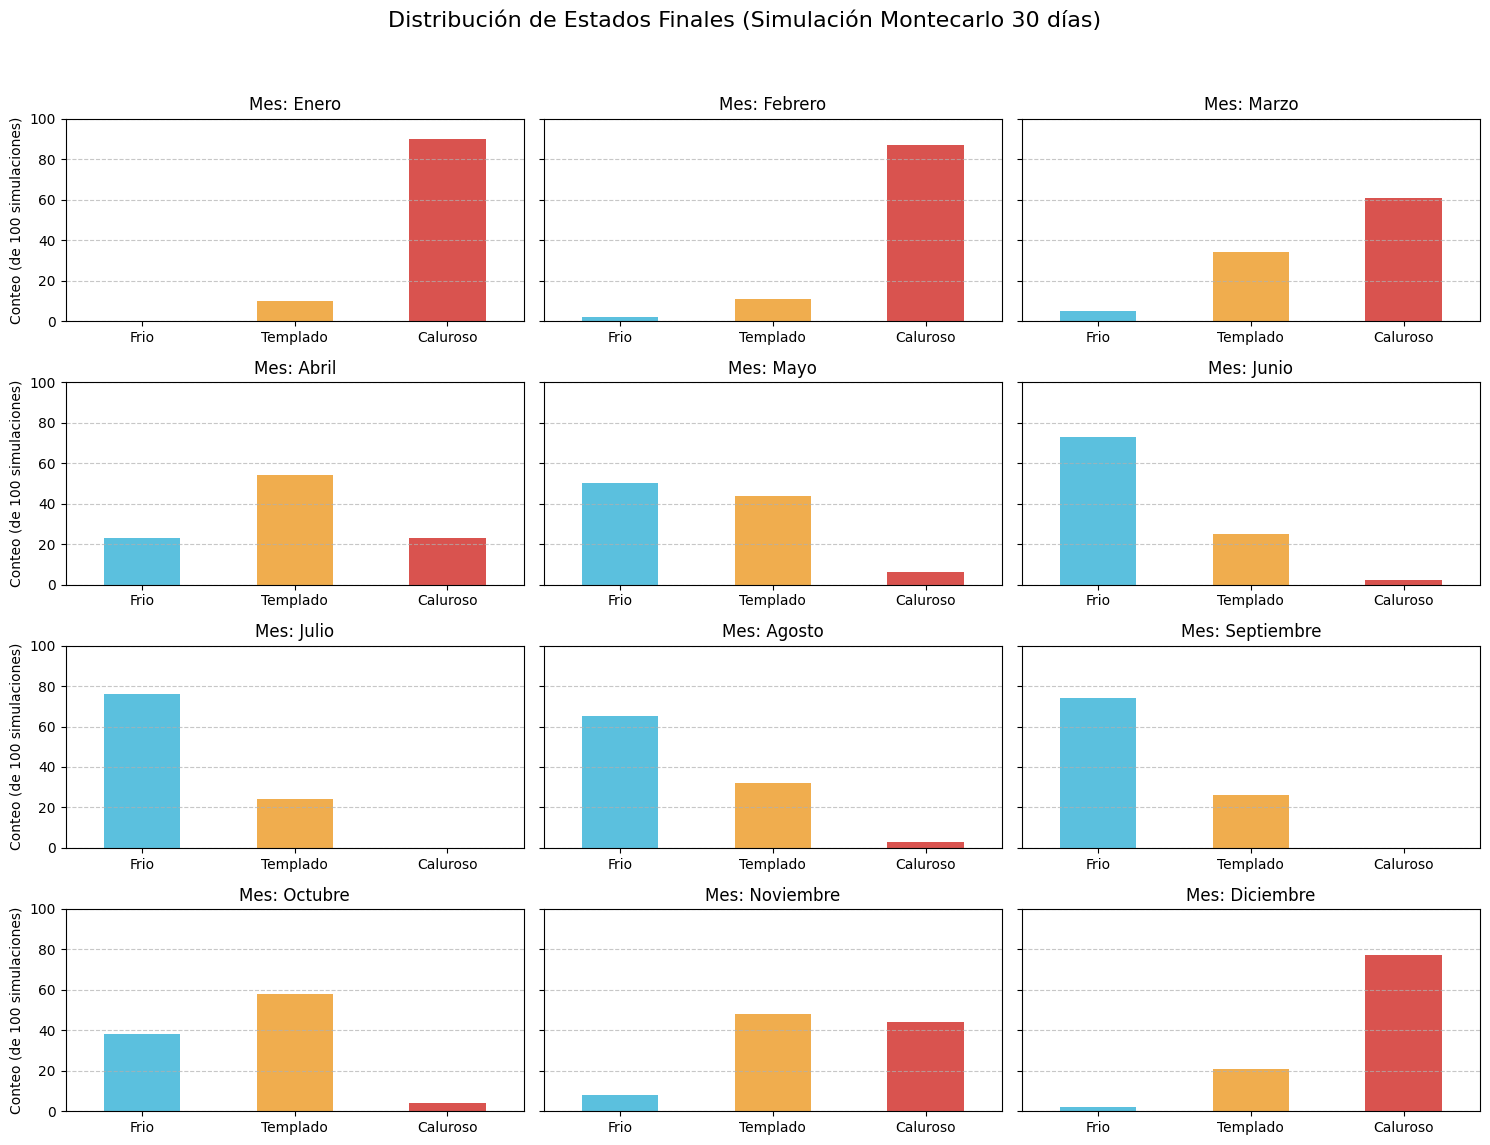

In [45]:
# Colores consistentes para los estados
colores_estado = {'Frio': '#5bc0de', 'Templado': '#f0ad4e', 'Caluroso': '#d9534f'}

# Creamos una figura de 4 filas y 3 columnas
fig, axes = plt.subplots(4, 3, figsize=(15, 12), sharey=True)

for mes in range(1, 13):
    # Calculamos la posición en la cuadrícula (ej. mes 1 -> [0,0], mes 12 -> [3,2])
    fila_idx = (mes - 1) // 3
    col_idx = (mes - 1) % 3
    ax = axes[fila_idx, col_idx]

    # Obtenemos los resultados de la simulación para ese mes
    resultados_idx = resultados_simulacion[mes]
    
    # Mapeamos los índices (0, 1, 2) de vuelta a las etiquetas ('Frio', 'Templado', ...)
    resultados_etiquetas = [etiquetas_estados[i] for i in resultados_idx]
    
    # Contamos los resultados y los reordenamos
    conteo = pd.Series(resultados_etiquetas).value_counts().reindex(estados_ordenados).fillna(0)
    
    # Graficamos el histograma (gráfico de barras)
    conteo.plot(
        kind='bar',
        ax=ax,
        title=f'Mes: {mes_nombres[mes]}',
        color=[colores_estado[estado] for estado in conteo.index]
    )
    
    # Solo ponemos la etiqueta Y en la columna de la izquierda
    if col_idx == 0:
        ax.set_ylabel(f'Conteo (de {N_SIMULACIONES} simulaciones)')
        
    ax.set_ylim(0, N_SIMULACIONES) # Aseguramos que el eje Y sea igual (0 a 100)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.tick_params(axis='x', rotation=0)

# Título general
plt.suptitle('Distribución de Estados Finales (Simulación Montecarlo 30 días)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajuste para el super-título

# Guardamos el gráfico
plt.savefig("simulacion_todos_meses.png")

## 7. Cálculo de Estados Estacionarios (Actividad 5)

Como vimos en la Clase 23, el **estado estacionario** ($\pi^*$) representa la distribución de probabilidades a largo plazo (después de infinitos pasos), independientemente del estado inicial.

Lo calculamos analíticamente encontrando el autovector (eigenvector) izquierdo correspondiente al autovalor (eigenvalue) 1 de cada matriz de transición.

Comparamos estos resultados analíticos con los resultados empíricos de nuestras simulaciones de Montecarlo.

In [35]:
def calcular_estado_estacionario(matriz_p):
    """
    Calcula el vector de estado estacionario de una matriz de transición.
    Resuelve pi = pi * P usando el autovector izquierdo.
    """
    # 1. Obtenemos los autovalores (w) y autovectores (v) de la matriz transpuesta
    # Usamos la transpuesta (P.T) porque queremos los autovectores *izquierdos*
    w, v = eig(matriz_p.T)
    
    # 2. Encontramos el índice del autovalor que es igual a 1 (o muy cercano)
    # np.argmin(np.abs(w - 1.0)) es una forma robusta de encontrar el 1
    idx = np.argmin(np.abs(w - 1.0))
    
    # 3. Extraemos el autovector correspondiente (es la columna idx de v)
    vector_estacionario = np.real(v[:, idx])
    
    # 4. Normalizamos el vector para que sus componentes sumen 1
    vector_estacionario_norm = vector_estacionario / np.sum(vector_estacionario)
    
    return vector_estacionario_norm

# --- Probemos la función con nuestra matriz de Julio (mes 7) ---
pi_julio = calcular_estado_estacionario(matrices_transicion[7])
print("\n--- Estado Estacionario (Julio) ---")
print(f"Probabilidades [Frio, Templado, Caluroso]: {pi_julio.round(3)}")
print(f"Suma (debe ser 1): {np.sum(pi_julio):.1f}")

# Lista para guardar los resultados analíticos
resultados_estacionarios = []

for mes in range(1, 13):
    matriz = matrices_transicion[mes]
    pi_vector = calcular_estado_estacionario(matriz)
    resultados_estacionarios.append(pi_vector)
    
    # Obtenemos los resultados de la simulación de Montecarlo para comparar
    conteo_mc = pd.Series(
        [etiquetas_estados[i] for i in resultados_simulacion[mes]]
    ).value_counts().reindex(estados_ordenados).fillna(0)
    prob_mc = (conteo_mc / conteo_mc.sum()).values
    
    print(f"\nMes: {mes_nombres[mes]}")
    print(f"  Analítico (Estacionario): {[f'{p:.2f}' for p in pi_vector]}")
    print(f"  Simulación (Montecarlo):  {[f'{p:.2f}' for p in prob_mc]}")

# --- Convertir a DataFrame para fácil visualización ---
df_comparacion = pd.DataFrame(
    resultados_estacionarios,
    columns=estados_ordenados,
    index=mes_nombres.values()
)

print("\n--- Tabla Comparativa: Estados Estacionarios (Probabilidades) ---")
print(df_comparacion.round(3))


--- Estado Estacionario (Julio) ---
Probabilidades [Frio, Templado, Caluroso]: [0.781 0.209 0.01 ]
Suma (debe ser 1): 1.0

Mes: Enero
  Analítico (Estacionario): ['0.00', '0.10', '0.90']
  Simulación (Montecarlo):  ['0.00', '0.08', '0.92']

Mes: Febrero
  Analítico (Estacionario): ['0.00', '0.12', '0.87']
  Simulación (Montecarlo):  ['0.00', '0.12', '0.88']

Mes: Marzo
  Analítico (Estacionario): ['0.04', '0.37', '0.60']
  Simulación (Montecarlo):  ['0.06', '0.32', '0.62']

Mes: Abril
  Analítico (Estacionario): ['0.25', '0.50', '0.25']
  Simulación (Montecarlo):  ['0.27', '0.48', '0.25']

Mes: Mayo
  Analítico (Estacionario): ['0.52', '0.38', '0.10']
  Simulación (Montecarlo):  ['0.54', '0.39', '0.07']

Mes: Junio
  Analítico (Estacionario): ['0.71', '0.26', '0.03']
  Simulación (Montecarlo):  ['0.74', '0.23', '0.03']

Mes: Julio
  Analítico (Estacionario): ['0.78', '0.21', '0.01']
  Simulación (Montecarlo):  ['0.77', '0.21', '0.02']

Mes: Agosto
  Analítico (Estacionario): ['0.72', 

## 8. Visualización de Matriz como Grafo (Actividad 6)

Finalmente, como se pide en la Actividad 6 y se vio en la Clase 24, usamos la librería `networkx` para visualizar una de las matrices de transición (Julio) como un grafo de estados dirigido.

* Los **nodos** son los estados (Frio, Templado, Caluroso).
* Las **flechas (bordes)** representan la probabilidad ($p_{ij}$) de transicionar de un estado a otro. Solo mostramos probabilidades mayores al 1% para mantener el gráfico limpio.


--- Actividad 6: Graficando la Matriz de Transición (Julio) ---


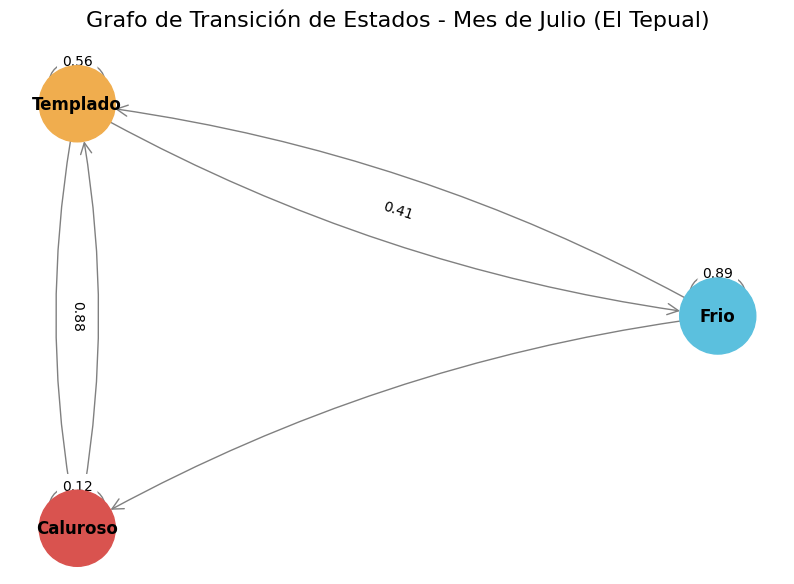

Gráfico de la matriz de transición guardado en 'matriz_grafo_julio.png'


In [ ]:
# 1. Seleccionamos la matriz y las etiquetas (de pasos anteriores)
matriz_a_graficar = matrices_transicion[7] # Usamos Julio como ejemplo
etiquetas = estados_ordenados

# 2. Creamos el grafo dirigido (DiGraph) desde la matriz
G = nx.from_numpy_array(matriz_a_graficar, create_using=nx.DiGraph)

# 3. Mapeamos los índices (0,1,2) a las etiquetas de texto
label_map = {i: etiqueta for i, etiqueta in enumerate(etiquetas)}

# 4. Obtenemos las probabilidades (weights) para las etiquetas de los bordes
edge_labels = {}
for (u, v, data) in G.edges(data=True):
    prob = data['weight']
    if prob > 0.01: # Solo mostrar probabilidades > 1%
        edge_labels[(u, v)] = f"{prob:.2f}" # Redondear a 2 decimales

# 5. Definimos un layout circular (simple y ordenado)
pos = nx.circular_layout(G)

# 6. Dibujamos el grafo
plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(
    G, pos, 
    node_size=3000, 
    node_color=['#5bc0de', '#f0ad4e', '#d9534f'] # Colores de los estados
)

nx.draw_networkx_labels(
    G, pos, 
    labels=label_map, 
    font_size=12,
    font_weight='bold'
)

nx.draw_networkx_edges(
    G, pos, 
    node_size=3000,
    arrowstyle='->',
    arrowsize=20,
    edge_color='gray',
    connectionstyle='arc3,rad=0.1' # Flechas curvas para que no se tapen
)

# 7. Agregamos las etiquetas de probabilidad
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_size=10
)

plt.title('Grafo de Transición de Estados - Mes de Julio (El Tepual)', fontsize=16)
plt.axis('off') # Ocultar ejes
plt.savefig("matriz_grafo_julio.png")
plt.show()

print("Gráfico de la matriz de transición guardado en 'matriz_grafo_julio.png'")

## 9. Conclusiones

Este desafío ha demostrado exitosamente la viabilidad de modelar el clima de la estación El Tepual (Puerto Montt) como un proceso estocástico utilizando Cadenas de Markov.

### 9.1. Resumen de Hallazgos

1.  **Extracción y Discretización Exitosa:** Se logró extraer, limpiar y rellenar 22 años de datos diarios de temperatura. La discretización mediante terciles (`Frio`, `Templado`, `Caluroso`) permitió clasificar el 100% de los datos históricos en estados manejables.

2.  **Patrones Estacionales Claros:** Las 12 matrices de transición mensuales revelaron patrones estacionales evidentes. La matriz de Enero mostró una alta "inercia" (probabilidad > 0.93) de permanecer en el estado "Caluroso", mientras que la matriz de Julio mostró una inercia similar (> 0.89) en el estado "Frio". El grafo de NetworkX (Actividad 6) visualizó claramente esta persistencia en los meses de invierno.

3.  **Validación del Modelo:** Los resultados de las simulaciones de Montecarlo (Actividad 4) convergieron a distribuciones muy similares a las calculadas analíticamente (Actividad 5). Por ejemplo, tanto la simulación como el cálculo analítico para Julio mostraron una probabilidad a largo plazo de ~80% de estar en "Frio", validando ambos métodos.

### 9.2. Limitaciones del Modelo

* **Propiedad de Markov:** La suposición clave de que el clima de mañana solo depende del de hoy es una simplificación. Los sistemas meteorológicos reales tienen "memoria" de varios días.
* **Discretización:** Agrupar temperaturas en solo 3 estados es una pérdida de información (p. ej., 5°C y 9.5°C son ambos "Frio", pero climáticamente diferentes).
* **Relleno de Datos:** La estrategia `ffill` (relleno hacia adelante) para los `NaN` es una suposición que puede introducir sesgos si faltan muchos días seguidos.

### 9.3. Trabajo Futuro

Para mejorar el modelo, se podría experimentar con Cadenas de Markov de orden superior (que consideren los últimos 2 o 3 días) o aumentar el número de estados (p. ej., "Muy Frio", "Frio", "Templado", "Caluroso", "Muy Caluroso") para una mayor precisión.